В рамках задания необходимо реализовать один из алгоритмов поиска оптимальной стратегии для среды Taxi из фреймворка Gymnasium.

In [2]:
import numpy as np
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio

from tqdm import tqdm

# 1 Инициализация и описание среды

In [3]:
env = gym.make("Taxi-v3", render_mode="rgb_array")

In [4]:
env.reset()

(414, {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 0, 0], dtype=int8)})

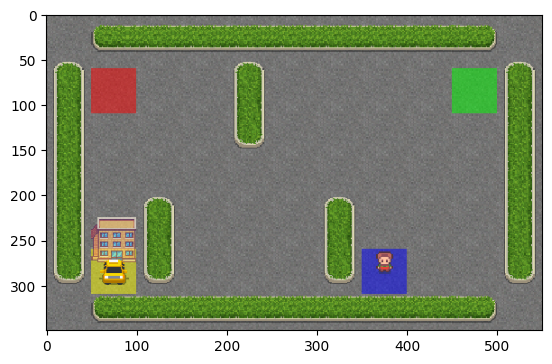

In [5]:
plt.imshow(env.render());

Среда представляет собой сетку размера 5*5 с 4 выделенными клетками: R(ed), G(reen), Y(ellow) и B(lue). В начале каждого эпизода такси появляется в случайной клетке, а пассажир в одной из выделенных клеток. Такси подъезжает к месту нахождения пассажира, забирает пассажира, подъезжает к пункту назначения пассажира (еще одна из четырех выделенных клеток), и затем высаживает пассажира. Как только пассажир высаживается, эпизод заканчивается.

Есть 6 дискретных детерминированных действий:
1. Движение на юг
2. Движение на север
3. Движение на восток
4. Движение на запад
5. Посадка пассажира
6. Высадка пассажира

Пространство состояний характеризуется 4 параметрами:
1. taxi_row - место нахождения такси по вертикали
2. taxi_col - место нахождения такси по горизонтали
3. passenger_location - место нахождения пассажира
4. destination - пункт назначения пассажира

Награды:
- -1 за шаг, если не будет активирована другая награда
- +20 за доставку пассажира
- -10 за ошибочное выполнение действий «посадка» и «высадка»

# 2 Обучение

Для обучения политики был выбран алгоритм SARSA.

Число состояний и действий:

In [6]:
nS, nA = env.observation_space.n, env.action_space.n
nS, nA

(500, 6)

In [7]:
def get_random_Q(env):
    Q = np.random.random(size=(nS, nA))
    return Q

def compute_policy_by_Q(env, Q):
    return np.argmax(Q, axis=1)

In [8]:
def Sarsa_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    s, a = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
    for _ in range(1000):
        observation, reward, terminated, truncated, info = env.step(a)
        s_prime, a_prime = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * Q[s_prime][a_prime] - Q[s][a])
        s, a = s_prime, a_prime
        if terminated:
            break

In [9]:
def Sarsa_learning(alpha=0.1, gamma=0.9, total_episodes=20000):
    env = gym.make("Taxi-v3", render_mode="rgb_array")
    total_episodes = total_episodes

    Q_hist_Sarsa = [ ]

    Q = get_random_Q(env)
    pi = compute_policy_by_Q(env, Q)

    for n in tqdm(range(1, total_episodes+1)):
        Sarsa_learning_episode(env, pi, Q, alpha=alpha, epsilon= 1. / (np.log(n)+1), gamma=gamma)
        pi = compute_policy_by_Q(env, Q)
        Q_hist_Sarsa.append(np.copy(Q))

    env.close()
    return pi, Q_hist_Sarsa

Обучим алгоритм на 20 тыс. эпизодов с дисконтирующим фактором 0,9 и коэффициентом забывания 0,1.

In [10]:
pi, Q_hist_Sarsa = Sarsa_learning(alpha=0.1, gamma=0.9, total_episodes=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 20000/20000 [00:25<00:00, 782.62it/s] 


# 3 Тестирование

Протестируем политику на 10 тыс. эпизодов. Ограничим максимальное число шагов 1000.

In [11]:
def conduct_experiments_pi(env, pi, num_experiments=10000):
    num_steps, total_reward = [], []
    for _ in range(num_experiments):
        env.reset()
        num_steps.append(0)
        total_reward.append(0)
        for _ in range(1000):
            observation, reward, terminated, truncated, info = env.step(pi[env.env.s])
            total_reward[-1] += reward
            num_steps[-1] += 1
            if terminated:
                break
    env.close()
    return total_reward, num_steps

In [12]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()

total_reward, num_steps = conduct_experiments_pi(env, pi, num_experiments=10000)

Средняя награда и число шагов:

In [13]:
print(np.mean(total_reward))
print(np.mean(num_steps))

7.7472
13.2528


Средняя награда примерно равна награде за успешную доставку пассажира (20) за вычетом среднего числа шагов (13), так как награда за каждый шаг составляет -1.

Визуализируем один эпизод игры с оптимальной стратегией, для этого сохраним его в виде gif-файла.

In [15]:
def save_episode_gif(env, pi):
    num_steps, total_reward = 0, 0
    env.reset()
    frames = [env.render()]    
    for _ in range(1000):
        observation, reward, terminated, truncated, info = env.step(pi[env.env.s])
        frames.append(env.render())
        total_reward += reward
        num_steps += 1
        if terminated:
            break

    env.close()
    imageio.mimwrite(os.path.join('episode.gif'), frames, fps=2)
    return total_reward, num_steps

In [16]:
total_reward1, num_steps1 = save_episode_gif(env, pi)

Награда за этот эпизод и число шагов.

In [17]:
print(total_reward1)
print(num_steps1)

4
17


Исследуем влияние таких гиперпараметров, как коэффициент забывания, дисконтирующий фактор и число обучающих эпизодов на качество обучения. Для этого обучим несколько политик с разными значениями этих гиперпараметров и протестируем их на 10 тыс. эпизодов.

In [40]:
alpha_list = [0.05, 0.1, 0.2]
gamma_list = [0.7, 0.9, 0.99]
total_episodes_list = [10000, 20000, 30000]

total_reward_dict = {}

for total_episodes in total_episodes_list:
    total_reward_df = pd.DataFrame(columns=[f'alpha = {x}' for x in alpha_list])
    for alpha in alpha_list:
        for gamma in gamma_list:

            pi, Q_hist_Sarsa = Sarsa_learning(alpha=alpha, gamma=gamma, total_episodes=total_episodes)

            env = gym.make("Taxi-v3", render_mode="rgb_array")
            env.reset()
            total_reward, num_steps = conduct_experiments_pi(env, pi, num_experiments=10000)

            total_reward_df.loc[f'gamma = {gamma}', f'alpha = {alpha}'] = np.mean(total_reward)
    total_reward_dict[f'total_episodes = {total_episodes}'] = total_reward_df

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.s` for environment variables or `env.get_wrapper_attr('s')` that will search the reminding wrappers.
  logger.warn(
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\Lada\VSCodeProjects\OTUS\.venv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.s to get variables from other wrappers is deprecated and will be removed in

In [41]:
for total_episodes in total_episodes_list:
    display(total_reward_dict[f'total_episodes = {total_episodes}'])

,alpha = 0.05,alpha = 0.1,alpha = 0.2
gamma = 0.7,-421.6408,-400.375,-768.5235
gamma = 0.9,4.6711,2.8498,-19.696
gamma = 0.99,7.465,7.3838,7.5366


,alpha = 0.05,alpha = 0.1,alpha = 0.2
gamma = 0.7,-357.3669,-371.8214,-629.6105
gamma = 0.9,7.7804,7.4551,-94.4284
gamma = 0.99,7.682,7.2908,-63.5792


,alpha = 0.05,alpha = 0.1,alpha = 0.2
gamma = 0.7,-209.5335,-519.5893,-721.6821
gamma = 0.9,7.1968,7.6756,-110.9276
gamma = 0.99,7.4668,7.5633,-37.0143


# 4 Выводы

Для решения задачи обучения с подкреплением был реализован алгоритм SARSA в среде Taxi из фреймворка Gymnasium. Алгоритм обучался на 20 тыс. эпизодов с дисконтирующим фактором 0,9 и коэффициентом забывания 0,1. Полученная политика была протестирована на 10 тыс. эпизодов с ограничением максимального числа шагов 1000. Средняя награда и среднее число шагов составили 7.6376 и 13.3624 соответственно. Полученная политика успешно справляется с прохождением эпизодов. Визуализация прохождения 1 эпизода была сохранена в файле `episode.gif`.

Также было исследовано влияние таких гиперпараметров, как коэффициент забывания, дисконтирующий фактор и число обучающих эпизодов, на качество обучения. Для этого алгоритм SARSA был обучен несколько раз с разными значениями этих гиперпараметров:
- коэффициент забывания alpha = [0.05, 0.1, 0.2]
- дисконтирующий фактор gamma = [0.7, 0.9, 0.99]
- число обучающих эпизодов = [10000, 20000, 30000]

Затем полученные политики были протестированы на 10 тыс. эпизодов для подсчета средней награды. Результаты представлены ниже.

In [ ]:
for total_episodes in total_episodes_list:
    display(total_reward_dict[f'total_episodes = {total_episodes}'])

,alpha = 0.05,alpha = 0.1,alpha = 0.2
gamma = 0.7,-421.6408,-400.375,-768.5235
gamma = 0.9,4.6711,2.8498,-19.696
gamma = 0.99,7.465,7.3838,7.5366


,alpha = 0.05,alpha = 0.1,alpha = 0.2
gamma = 0.7,-357.3669,-371.8214,-629.6105
gamma = 0.9,7.7804,7.4551,-94.4284
gamma = 0.99,7.682,7.2908,-63.5792


,alpha = 0.05,alpha = 0.1,alpha = 0.2
gamma = 0.7,-209.5335,-519.5893,-721.6821
gamma = 0.9,7.1968,7.6756,-110.9276
gamma = 0.99,7.4668,7.5633,-37.0143


Линейная зависимость качества от этих гиперпараметров прослеживается не везде. Наилучшее качество было получено со следующими гиперпараметрами:
1. alpha = 0.05, gamma = 0.9, total_episodes = 20000
2. alpha = 0.05, gamma = 0.99, total_episodes = 20000
3. alpha = 0.1, gamma = 0.9, total_episodes = 30000